This is using info from `histogram_FES_to_confout` as well as `sugar_coordination_analysis`

I want to be able to check out the grids that I should take for the sugar coordination picture, and then I can get some info using this script from the dataframe I made in `sugar_coordination_analysis` if I need

# Pt. 1 . Literally the same script from `histogram_FES_to_confout`, just now its a function so I can plot many grids at once

In [1]:
import os
import pickle
import sys
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


logging.getLogger("stringmethod").setLevel(logging.ERROR)
sys.path.append("../../string-method-gmxapi/")
import string_tica_msm as my_msm

['/data2/GLUT5_string/string/analysis/scripts', '/home/semccomas/anaconda3/envs/string_method/lib/python38.zip', '/home/semccomas/anaconda3/envs/string_method/lib/python3.8', '/home/semccomas/anaconda3/envs/string_method/lib/python3.8/lib-dynload', '', '/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages', '../../string-method-gmxapi/', '../../string-method-gmxapi/stringmethod/simulations/../../']


In [2]:
MSM_sim_dir = "../../string_sims/TMD_initial_path/influx_BFRU_gate_CV"

F = np.load(f'{MSM_sim_dir}/F_MSM.npy')
extent = np.load(f'{MSM_sim_dir}/extent_MSM.npy')
cv_proj = np.load(f'{MSM_sim_dir}/cv_proj_MSM.npy')  #IC, EC


cv_labels = ["Intracellular gate (nm)", "Extracellular gate (nm)"]

xlim = (0.9,1.6)
ylim = (0.8,1.6)

In [3]:
def get_square(data, IC_leftmost, IC_rightmost, EC_lowermost, EC_uppermost, IC_index, EC_index):
    '''
    IC index should be 0 or 1 depending on where it exists in data, same for EC
    '''
    
    col0m = np.logical_and(data[:,IC_index]>= IC_leftmost, data[:,IC_index]<=IC_rightmost) #IC column mask
    col1m = np.logical_and(data[:,EC_index]>= EC_lowermost, data[:,EC_index]<=EC_uppermost) #EC column mask

    col0_1 = data[col0m & col1m]
    
    IC_selected_region = col0_1[:,IC_index]
    EC_selected_region = col0_1[:,EC_index]
    
    return IC_selected_region, EC_selected_region

In [4]:
def get_grid_square(grid):
    IC_extent = np.linspace(extent[0], extent[1], 55)
    EC_extent = np.linspace(extent[2], extent[3], 55)

    # define square
    grid_label = 0
    grid_label_coord_dict = {}

    for y_grid_index in range(0, 55):
        for x_grid_index in range(0, 55):
            if x_grid_index < 54 and y_grid_index < 54:
                IC_leftmost = IC_extent[x_grid_index] - 0.01
                IC_rightmost = IC_extent[x_grid_index + 1] + 0.01
                EC_uppermost = EC_extent[y_grid_index + 1] + 0.01
                EC_lowermost = EC_extent[y_grid_index] - 0.01

                coords = [IC_leftmost, IC_rightmost, EC_uppermost, EC_lowermost]    
                grid_label_coord_dict[grid_label] = coords
                grid_label = grid_label + 1

    IC_leftmost, IC_rightmost, EC_uppermost, EC_lowermost = grid_label_coord_dict[grid]            
    
    
    
    
    
    #Get the IC&EC gate values where F is within specified range
    min_F = -1
    max_F = 15
    IC_min_indices = np.where(np.logical_and(F > min_F, F < max_F))[1]
    EC_min_indices = np.where(np.logical_and(F > min_F, F < max_F))[0]

    IC_min_vals = []
    EC_min_vals = []
    for val_IC, val_EC in zip(IC_extent[IC_min_indices], EC_extent[EC_min_indices]):
        IC_min_vals.append(val_IC)
        EC_min_vals.append(val_EC)

    all_min_vals = np.vstack((IC_min_vals, EC_min_vals)).T

    IC_selected_region, EC_selected_region = get_square(data = all_min_vals,
                                                        IC_leftmost=IC_leftmost,
                                                        IC_rightmost=IC_rightmost,
                                                        EC_lowermost=EC_lowermost,
                                                        EC_uppermost=EC_uppermost,
                                                        IC_index=0,
                                                        EC_index=1)

    all_min_vals_selected_region = np.vstack((IC_selected_region, EC_selected_region)).T
    
    
    
    
    
    
    ###### get where data is fitting square
    margin = np.diff(IC_extent)[0]/2 + 0.001  #dist between each point + a bit extra

    data = cv_proj[:,1,:] ## wondering if you need to only take the drift value of swarms, not starting...

    all_nearby_minima_square = []
    all_nearby_indices = []

    for IC_region_bead, EC_region_bead in all_min_vals_selected_region:
        IC_nearby = np.logical_and(data[:,0]>(IC_region_bead-margin), data[:,0]<(IC_region_bead+margin))
        EC_nearby = np.logical_and(data[:,1]>(EC_region_bead-margin), data[:,1]<(EC_region_bead+margin))
        all_nearby_minima_square.append(data[IC_nearby & EC_nearby])
        all_nearby_indices.append(np.where(IC_nearby & EC_nearby)[0])

    all_nearby_minima_square = np.array(all_nearby_minima_square)
    all_nearby_minima_square = np.concatenate(all_nearby_minima_square)

    all_nearby_indices = np.array(all_nearby_indices)
    all_nearby_indices = np.concatenate(all_nearby_indices)

    print(np.shape(all_nearby_minima_square))
    
    
    return grid_label_coord_dict, all_nearby_minima_square, all_min_vals_selected_region

Also, plot the atomistic points so you can compare these to the histos, if you want to

In [5]:
def get_G5_atomistic_gate(timestep):
    # get all pieces together, then colors and naming consistent in plots
    G5_Out = np.array(['OUT', 'Out Open', 'green', "Greens"])
    G5_OutOcc = np.array(['OUT-OCC', 'Out Occ.', 'grey', "Greys"])
    G5_Occ = np.array(['OCC', 'Occluded', 'red', "Reds"])
    G5_InOcc = np.array(['IN-OCC', 'In Occ.', 'orange', "Oranges"])
    G5_In = np.array(['IN', 'In Open', 'blue', "Blues"])
    all_sims = np.array([G5_Out, G5_OutOcc, G5_Occ, G5_InOcc, G5_In])

    indir = '/data2/GLUT5_string/string/analysis/textfiles_out/EC_IC_gate_refs'

 
    out_arr = []
    for n, sim in enumerate(all_sims):
        name = sim[0]
        ec = np.loadtxt(f"{indir}/{name}.EC.{timestep}.xvg")[1]
        ic = np.loadtxt(f"{indir}/{name}.IC.{timestep}.xvg")[1]
        
        
        temp = np.append(all_sims[n], [f'EC: {str(ec)}', f'IC: {str(ic)}'])
        out_arr.append(temp)

    out_arr = np.array(out_arr)
    return out_arr

In [6]:
plot_atomistic = True
mix_atom_and_FES = True
name = 'start_model'
#name = 'end_atom'
atom_sims = get_G5_atomistic_gate(name)

Use the atom sims coordinates to find the closest points for the grid histos

In [7]:
if plot_atomistic and name == 'start_model' and not mix_atom_and_FES:
    grids = [2059,1525,823,155] 
elif plot_atomistic and name == 'end_atom' and not mix_atom_and_FES:
    grids = [2223,1199,837,131,146] 
elif not plot_atomistic and not mix_atom_and_FES:
    grids = [2223,1954,1631,1464, 1194, 816, 930, 827, 725, 730, 515, 299, 199]
elif mix_atom_and_FES:
    #816 and 730 are added based on FES. 816 is this pre-occluded state, 730 is what I assume to be
    ## GLUT5's natural inward occluded state
    #grids = [2059,1525,816,823,730,155] 
    grids = [2223,1631,816,823,730,155]
    
black_data_all = []
orange_data_all = []
for grid in grids:
    grid_label_coord_dict, black_data, orange_data = get_grid_square(grid)
    black_data_all.append(black_data)
    orange_data_all.append(orange_data)

(2456, 2)
(2075, 2)
(1835, 2)
(739, 2)
(1981, 2)
(175, 2)


/tmp/ipykernel_29027/2696020447.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_nearby_minima_square = np.array(all_nearby_minima_square)
/tmp/ipykernel_29027/2696020447.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_nearby_indices = np.array(all_nearby_indices)


In [11]:
margin = 0.007
#margin = 00703
nearest_grid_dict = {}
for n in atom_sims:
    ic = float(n[-1].split(' ')[1])
    ec = float(n[-2].split(' ')[1])
    
    k_list = []
    for k,v in grid_label_coord_dict.items():
        ic_l,ic_r,ec_u,ec_l = v
        if np.mean([ic_l,ic_r]) >= ic - margin and np.mean([ic_l,ic_r]) <= ic + margin:
            if np.mean([ec_u,ec_l]) >= ec - margin and np.mean([ec_u,ec_l]) <= ec + margin:
                k_list.append(k)
                print(n[0], ic, ec, k)
                nearest_grid_dict[n[0]]=k_list

#np.save('../textfiles_out/nearest_grid_per_state.npy', nearest_grid_dict)

OUT 1.024 1.388 2059
OUT-OCC 1.1 1.237 1525
OCC 1.097 1.035 823
IN-OCC 1.248 0.799 26
IN 1.498 0.836 155


2022-03-25 16:11:42 matplotlib.pyplot-DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-03-25 16:11:42 matplotlib.colorbar-DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc9ce1de790>
2022-03-25 16:11:42 matplotlib.colorbar-DEBUG: Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc9ce1de790> on colorbar
2022-03-25 16:11:42 matplotlib.colorbar-DEBUG: Setting pcolormesh
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXSizeTwoS

2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'KacstTitleL' (KacstTitleL.ttf) normal normal 400 normal>) = 10.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Medium.ttc) normal normal 500 normal>) = 10.145
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Lato' (Lato-ThinItalic.ttf) italic normal 200 normal>) = 11.24
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXVariants' (STIXVariants-Regular.otf) normal normal 400 normal>) = 10.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal 700 normal>) = 10.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Norasi' (Norasi-Bold.ttf) normal normal 700 normal>) = 10.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Liberation Mono' (LiberationMono-Regular.ttf) normal normal 400 normal>) =

2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXIntegralsD' (STIXIntegralsD-Bold.otf) normal normal 700 normal>) = 10.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'FreeSans' (FreeSans.ttf) normal normal 400 normal>) = 10.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'KacstDecorative' (KacstDecorative.ttf) normal normal 500 normal>) = 10.145
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Italic.ttf) italic normal 400 condensed>) = 11.25
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal 400 normal>) = 10.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Tlwg Typist' (TlwgTypist-Bol

2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'KacstFarsi' (KacstFarsi.ttf) normal normal 500 normal>) = 10.145
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal 700 condensed>) = 1.535
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Khmer OS' (KhmerOS.ttf) normal normal 400 normal>) = 10.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Lato' (Lato-Hairline.ttf) normal normal 100 normal>) = 10.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Waree' (Waree-Bold.ttf) normal normal 700 norma

2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Norasi' (Norasi-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Laksaman' (Laksaman-Italic.ttf) italic normal 400 normal>) = 11.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Padauk Book' (Padauk-bookbold.ttf) normal normal 700 normal>) = 10.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Kinnari' (Kinnari-Italic.ttf) italic normal 500 normal>) = 11.145
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'OpenSymbol' (opens___.ttf) normal normal 400 normal>) = 10.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Tlwg Typo' (TlwgTypo-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXNonUnicode' (STIXNonUnicode-Italic.otf) italic normal 400 normal>) = 

2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXSizeThreeSym' (S

2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Tlwg Mono' (TlwgMono-Bold.ttf) normal normal 700 normal>) = 10.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Lato' (Lato-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Lohit Punjabi' (Lohit-Punjabi.ttf) normal normal 400 normal>) = 10.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Norasi' (Norasi.ttf) normal normal 400 normal>) = 10.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXNonUnicode' (STIXNonUnicode-BoldItalic.otf) italic normal 700 normal>) = 11.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal 700 normal>) = 10.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Padauk' (Padauk.ttf) normal normal 400 normal>) = 10.05
2022

2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntegralsUpSm-Bold.otf) normal normal 700 normal>) = 10.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Tlwg Typist' (TlwgTypist-Oblique.ttf) oblique normal 500 normal>) = 11.145
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal 700 normal>) = 10.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Lato' (Lato-Thin.ttf) normal normal 200 normal>) = 10.24
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXVariants' (STIXVariants-Bold.otf) normal normal 700 normal>) = 10.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) it

2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'FreeSerif' (FreeSerifBold.ttf) normal normal 700 normal>) = 10.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Garuda' (Garuda-Bold.ttf) normal normal 700 normal>) = 10.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXSizeThreeSym' (STIXSizeThreeSym-Bold.otf) normal normal 700 normal>) = 10.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIX' (STIX-Italic.otf) italic normal 400 no

2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Laksaman' (Laksaman-Bold.ttf) normal normal 700 normal>) = 10.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-BoldItalic.ttf) italic normal 700 condensed>) = 11.535
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Tlwg Typo' (TlwgTypo.ttf) normal normal 500 normal>) = 10.145
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Tibetan Machine Uni' (TibetanMachineUni.ttf) normal normal 400 normal>) = 10.05
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXIntegralsSm' (STIXIntegralsSm-Bold.otf) normal normal 700 normal>) = 10.335
2022-03-25 16:11:42 matplotlib.font_manager-DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0 to DejaVu Sans ('/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/ma

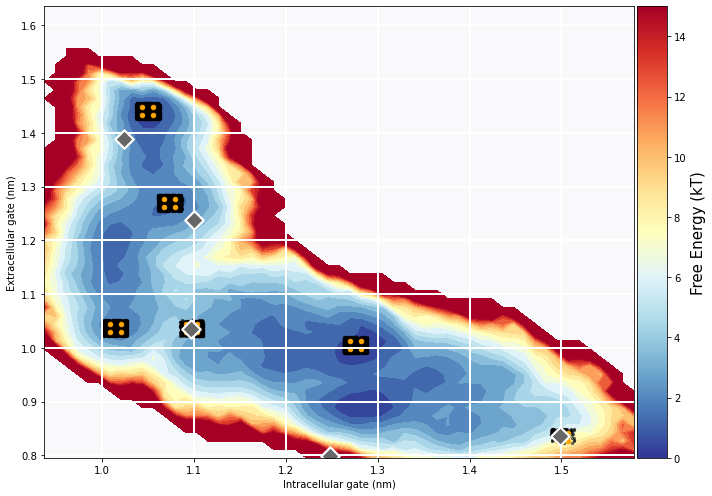

In [25]:
%matplotlib inline

f_max = 15


fig, ax = my_msm.plot_2D_heatmap(
    F,
    extent,
    f_max=f_max,
    cbar_label="Free Energy (kT)",
    xlabel=cv_labels[0],
    ylabel=cv_labels[1],
    xlim= None,
    ylim= None
)

fig.tight_layout()

if plot_atomistic:
    for n in atom_sims:
        ic = float(n[-1].split(' ')[1])
        ec = float(n[-2].split(' ')[1])
        ax.scatter(ic, ec, color = ['#666666'], edgecolor = 'white', \
                   s = 170, zorder=2, marker='D', linewidth = 2.2)

        
for black_data,orange_data in zip(black_data_all, orange_data_all):
    ax.scatter(black_data[:,0], black_data[:,1], s = 5, alpha = 0.5, c = 'black')
    ax.scatter(orange_data[:,0], orange_data[:,1], c = 'orange',s = 20)

plt.show()

# Pt 2, retrieving the sugar info here from `sugar_coordination_analysis`

In [26]:
cluster_info_df = pd.read_pickle('../textfiles_out/gmx_cluster_files/cluster_and_OH_info_df.pkl')
cluster_info_df = cluster_info_df.loc[grids,:]
max_pct_df = cluster_info_df.loc[grids,'max_percentage']
cluster_info_df

,cluster_labels,percentage_of_total,total_frames,total_sig_frames,max_percentage,mean_percentage,std_percentage,n_clusters,nearby_OH1,hbond_OH1,nearby_OH2,hbond_OH2,nearby_OH3,hbond_OH3,nearby_OH4,hbond_OH4,nearby_OH6,hbond_OH6
histogram,,,,,,,,,,,,,,,,,,
2223,"[cluster 1, cluster 2, cluster 4, cluster 5, c...","[13.28, 10.78, 29.32, 0.38, 7.39, 2.63, 2.38, ...",1000,798,29.32,5.882,7.410,17,"[GLN:281, GLN:282, HSD:380]",None,"[GLN:282, ASN:287, HSD:380]",[ASN:287],[VAL:29],None,[ILE:163],None,"[THR:164, ASN:318, HSD:380, SER:385]",None
1631,"[cluster 2, cluster 3, cluster 4, cluster 5, c...","[23.62, 0.77, 0.33, 47.35, 2.54, 2.32, 17.33, ...",1000,906,47.35,7.142,13.106,14,"[VAL:286, HSD:380, SER:385]",None,"[THR:164, ASN:318, ALA:381, SER:385]",[ASN:318],"[THR:164, ILE:167, TYR:290, ASN:318]",[ASN:318],"[VAL:286, ASN:287, TYR:290]",[ASN:287],"[ILE:163, THR:164, ILE:167]",None
816,"[cluster 1, cluster 2, cluster 3, cluster 4, c...","[17.07, 10.8, 1.33, 2.53, 3.47, 41.33, 0.8, 10...",1000,750,41.33,5.000,9.365,20,"[VAL:29, PHE:71]",None,[ASN:287],None,"[ASN:287, TYR:290, HSD:380]",[ASN:287],"[ILE:163, ILE:167, TYR:290]",None,"[GLN:160, ASN:287]",None
823,"[cluster 1, cluster 5, cluster 9, cluster 10, ...","[77.2, 3.97, 8.98, 4.15, 0.52, 1.21, 0.52, 0.5...",690,579,77.20,10.001,22.539,10,"[GLN:160, SER:385, PRO:386]",[GLN:160],"[VAL:286, SER:385]",[SER:385],[],None,"[TYR:25, ASN:287]",None,"[ILE:167, TYR:290]",None
730,"[cluster 1, cluster 2, cluster 3, cluster 8, c...","[77.83, 12.8, 3.43, 4.0, 0.57, 0.57, 0.8]",1000,875,77.83,14.286,26.246,7,"[VAL:286, TYR:290, SER:385]",[SER:385],"[GLN:282, VAL:286, TYR:290, HSD:412]",None,"[GLN:282, HSD:412, ASN:416]",[HSD:412],"[TYR:25, GLN:160, ILE:163]",None,"[VAL:29, ASN:287, TYR:290, TYR:291]",None
155,"[cluster 1, cluster 2, cluster 3]","[40.0, 56.3, 3.7]",161,135,56.30,33.333,21.985,3,"[GLN:160, ILE:163, THR:164, SER:385]",None,"[VAL:286, TYR:290, HSD:380]",[HSD:380],"[GLN:282, VAL:286, HSD:380, SER:385]",None,"[TYR:25, GLN:160, ILE:163]",[GLN:160],"[VAL:29, TYR:290]",None


Here I would like to see how this plot compares to the original plot I did of the sugar occupancy:

In [18]:
from IPython.display import Image
Image(url='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F18fee6b5-f71b-4063-a838-a1220b6b5dc8%2FUntitled.png?table=block&id=580055d2-874c-40ec-b475-0e5beec693b1&spaceId=dda02fec-82d7-47f4-878e-831947b86d5a&width=2000&userId=b7ed4d94-460e-4df2-871b-cc74cbb0bf44&cache=v2', width=300)

2022-03-28 11:57:52 matplotlib.colorbar-DEBUG: locator: <matplotlib.ticker.FixedLocator object at 0x7fc9bca45dc0>
2022-03-28 11:57:52 matplotlib.colorbar-DEBUG: Using auto colorbar locator <matplotlib.ticker.FixedLocator object at 0x7fc9bca45dc0> on colorbar
2022-03-28 11:57:52 matplotlib.colorbar-DEBUG: Setting pcolormesh


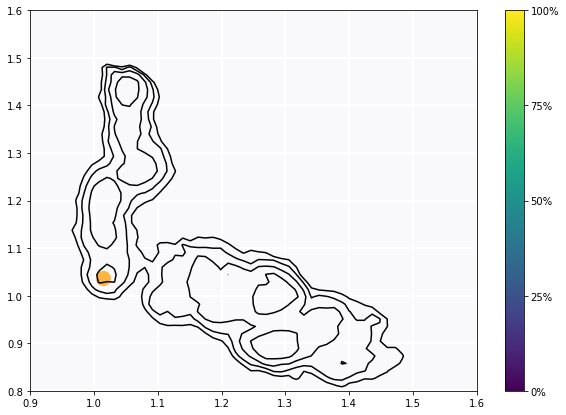

In [32]:
fig = plt.figure(figsize=(10,7))

colormap_colors = 'YlOrBr'
cmap_vals = plt.cm.get_cmap(colormap_colors)
color_vals = cmap_vals(np.linspace(0,1,100))

for grid in grids:
    IC_mean = np.mean(grid_label_coord_dict[grid][:2])
    EC_mean = np.mean(grid_label_coord_dict[grid][2:])
    
    scat = plt.scatter(IC_mean, EC_mean, s = 200,
                color=color_vals[int(max_pct_df[grid])], cmap = cmap_vals)

    

plt.contour(F, extent=extent, levels=[0,1,2,3,4], colors = 'black')

cbar = fig.colorbar(scat, ticks = [0, 0.25, 0.5, 0.75, 1],)
cbar.ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])


plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

In [28]:
import MDAnalysis as mda
logging.getLogger("MDAnalysis").setLevel(logging.WARNING)

2022-03-25 16:12:08 h5py._conv-DEBUG: Creating converter from 7 to 5
2022-03-25 16:12:08 h5py._conv-DEBUG: Creating converter from 5 to 7
2022-03-25 16:12:08 h5py._conv-DEBUG: Creating converter from 7 to 5
2022-03-25 16:12:08 h5py._conv-DEBUG: Creating converter from 5 to 7


First, choose a percentage that you want to describe of significant clusters (ie, not with only 1 member). Ex: if I want to take all the snapshots which would describe 70% of the possible poses, I choose `percent_to_describe` as 70.

Then, I will:
1. Sort the percentage of total, so that max percent is first
2. Loop through this sorted array, adding more percentage indices until you reach the threshold (ex 70)
   - The threshold is calculated by taking `sum(descriptive_percentage_group)`
   - The indices for these percentages is added to `descriptive_percentage_indexes`
3. Take the index of these maximum values to match the cluster ID (`cluster_ID[descriptive_percentage_indices`)
3. Cut away `'cluster ' `string and turn into int for Python ( -> `cluster_index_max`)
4. Write to trajectory, if the timeframe is == `cluster_index_max`

Note- if you would like to take all significant clusters (ie not 1), then set `percent_to_describe` to 100.

In [29]:
sugar_only = False

for grid in grids:
    clusters = mda.Universe('../confout_files/tpr_files/influx_BFRU_gate_CV.protonly.tpr',\
                                        f"../textfiles_out/gmx_cluster_files/histogram_{grid}/clusters.pdb")
    if sugar_only:
        system = clusters.select_atoms('resname BFRU')
        outname = 'sugar_only'
    else:
        system = clusters.select_atoms('all')
        outname = 'whole_sys'
    
    protein = clusters.select_atoms('protein')

    percent_to_describe = 85


    #for grid in grids:
    cluster_ID = np.array(cluster_info_df.loc[grid, 'cluster_labels'])
    pct = cluster_info_df.loc[grid, 'percentage_of_total']


    descriptive_percentage_group = []
    descriptive_percentage_indexes = []
    for n, index in enumerate(np.argsort(pct)[::-1]):
        if n == 0:    # add first automatically
            descriptive_percentage_group.append(pct[index])
            descriptive_percentage_indexes.append(index)
            descriptive_percentage_sum = sum(descriptive_percentage_group)

        else:      # keep adding until you get to percent_to_describe
            if descriptive_percentage_sum < percent_to_describe:
                descriptive_percentage_group.append(pct[index])
                descriptive_percentage_indexes.append(index)
                descriptive_percentage_sum = sum(descriptive_percentage_group)
            else:
                break
        final_pct = descriptive_percentage_sum


    cluster_index_max = cluster_ID[descriptive_percentage_indexes]
    cluster_index_max = np.char.replace(cluster_index_max, 'cluster ', '')
    cluster_index_max = np.array(cluster_index_max, dtype='int') - 1   # need python indexing for MDA

    with mda.Writer(f"../textfiles_out/gmx_cluster_files/histogram_{grid}/topframe_prot.pdb", protein.n_atoms) as W:
        for ts in clusters.trajectory:
            if ts.frame == cluster_index_max[0]:
                print(f'Writing top % frame (from model {ts.frame + 1}) for grid {grid}')
                W.write(system)
    
    with mda.Writer(f"../textfiles_out/gmx_cluster_files/histogram_{grid}/sig_clusters_for_pic.{outname}.pdb", system.n_atoms) as W:
        for ts in clusters.trajectory:
            if ts.frame in cluster_index_max:
                print(f' writing MODEL {ts.frame + 1} for grid {grid}')
                W.write(system)
            
print('Done!')

Writing top % frame (from model 4) for grid 2223


/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/semccomas/ana

 writing MODEL 1 for grid 2223
 writing MODEL 2 for grid 2223
 writing MODEL 4 for grid 2223
 writing MODEL 6 for grid 2223
 writing MODEL 14 for grid 2223
 writing MODEL 16 for grid 2223
 writing MODEL 23 for grid 2223
Writing top % frame (from model 5) for grid 1631
 writing MODEL 2 for grid 1631
 writing MODEL 5 for grid 1631
 writing MODEL 8 for grid 1631
Writing top % frame (from model 10) for grid 816
 writing MODEL 1 for grid 816
 writing MODEL 2 for grid 816
 writing MODEL 4 for grid 816
 writing MODEL 8 for grid 816
 writing MODEL 10 for grid 816
 writing MODEL 12 for grid 816
Writing top % frame (from model 1) for grid 823
 writing MODEL 1 for grid 823
 writing MODEL 9 for grid 823
Writing top % frame (from model 1) for grid 730
 writing MODEL 1 for grid 730
 writing MODEL 2 for grid 730
Writing top % frame (from model 2) for grid 155
 writing MODEL 1 for grid 155
 writing MODEL 2 for grid 155
Done!


Playing with representing RMSD of sugar. Just did it with gmx but I think we could incorporate this into the MDAnalysis section if we want to

In [79]:
g_2223 = np.loadtxt('../textfiles_out/gmx_cluster_files/histogram_2223/test.xvg')
g_823 = np.loadtxt('../textfiles_out/gmx_cluster_files/histogram_823/test.xvg')

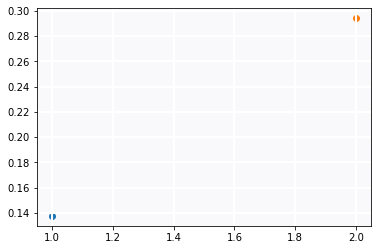

In [87]:
plt.scatter(1, np.mean(g_823[:,1]))
plt.scatter(2, np.mean(g_2223[:,1]))
